## Fitting Sigmoid to empirical NN
### Manually selecting bin size

In [60]:
# 9 Species: AT, CE, DM, ...
# 8 Classes: ER, ERDD, GEO, GEOGD ...(each with ~500 data points)
# normalization is done on each species seperetaly.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter

### normalization on AT,CE

In [62]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky', 'Original']
classes_pred = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky']
#data_locations = [r"/content/drive/MyDrive/random stuff/Adaptable-Sigmoids/data/AT"+c for c in classes]
# data_locations = [r"/Users/lizongli/Desktop/knnResearch/Adaptable-Sigmoids/data/EC"+c for c in classes]
data_locations = [r"../data/EC"+c for c in classes]
#data_locations_CE = [r"/content/drive/MyDrive/random stuff/Adaptable-Sigmoids/data/CE"+c for c in classes]
data_locations_CE = [r"../data/CE"+c for c in classes]
#prediction_p_value = "/content/drive/MyDrive/random stuff/Adaptable-Sigmoids/data/ATOriginal"
prediction_p_value = "../data/ECOriginal"

In [63]:
# from google.colab import drive
# drive.mount('/content/drive')

In [64]:
def combine_data(data_location,classes):
    df_comb = pd.DataFrame()
    i = 0
    for protein in data_location:
        df = pd.read_csv(protein, header = None, sep = ' ')
        df['class'] = classes[i]
        df_comb = pd.concat([df, df_comb])
        i += 1
    return df_comb

In [65]:
df_comb = combine_data(data_locations,classes)
df_class = df_comb['class']
df_comb = df_comb.drop("class", axis = 1)
df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
df_comb['class'] = df_class.reset_index(drop = True)

In [66]:
# df_CE = combine_data(data_locations_CE,classes)
# df_class_CE = df_CE['class']
# df_CE = df_CE.drop("class", axis = 1)
# df_CE = pd.DataFrame(MinMaxScaler().fit_transform(df_CE))
# df_CE['class'] = df_class_CE.reset_index(drop = True)

In [67]:
# calling data(data_frame, class_name) return Species-Class empirical data as an array
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

### helper functions

In [68]:
# calculating empirical data's shortest(NN) distance 
# real data is high-dimensional data points
def data_distance(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    print(np.array(shortest_distance))
    return np.array(shortest_distance)   # return an array of real data's NN distance


# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white',bins=100)   ## consider specifying <bins>
    ax.set_title(title)
    plt.show()
    return


# generate empirical CDF manually, satisfying:
# 1. F(x<=0) = 0
# 2. F(x_1) = 1/(n+1)
# 3. F(x_n/2) = 0.5
# 4. F(x_n) = n/(n+1)
# 5. F(x) < 1 for all x.
def empirical_CDF(data,title):
    '''
    return x,y data of CDF 
    '''    
    sort_data = np.sort(data)
    #print("data len: ",len(sort_data))
    x = np.concatenate(([0],sort_data))
    #print("x len : ",len(x))
    #print("first: ", x[0], "\nlast: ",x[-1])
    
    y = np.zeros((x.shape))
    for i in range(1,len(x)):
        y[i] = i/len(x)
    # plot_data_distance(x, "a")
    # print(plt.show())
    # print(x)
    plt.plot(x, y)
    plt.show()
    return x,y



# curve_fit()
def auto_curve_fit(data_NN, x, y, x_scale_factor, func, s, p_control=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting
    '''
    if p_control == "Gompertz":
        p0 = [1,1]
    elif p_control == "Weight":
        p0 = [np.median(data_NN)/x_scale_factor,1,0.5]
    else:
        p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
    
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter on "+str(func)[9:-22]+": ", popt)
    return popt

arctan_popt = {}

# def sigmoid_entropy(x, y, f):
#     return np.sum(y*np.log(f(x)) + (1-y)*np.log(1 - f(x)))

# plot fitted sigmoid and empirical curve in 1-y and y: i.e. y-axis = p-value and CDF
def sigmoids_for_class(data, name, factor, func_list, color_list, binning=False):
    if binning:
        x,y = binning_xy(data_binning(data))
    else:
        x,y = empirical_CDF(data, name)
    # plt.plot(x/factor, y)
    # plt.show()
    # print(y.shape)
    # axis[0] = 1-y = p_value (on log space)
    # axis[1] = y = CDF
    f,ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].set_title('1-y(p_value) of '+name)
    ax[0].set_yscale('log')
    ax[0].scatter(x,1-y, color='b',s=10)
    # ax[0].plot(x, 1-y, color="b")
    
    ax[1].set_title('y of '+name)
    ax[1].scatter(x,y, color='b',s=10)
    # ax[1].plot(x, y, color="b")
    
    print("For ",name," :")
    for i in range(len(func_list)):
        try:
            if i == 7:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Gompertz")
            elif i == 6:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y,p_control="Weight")
            else:
                p = auto_curve_fit(data,x,y,factor,func_list[i],s=y)
        except RuntimeError:
            print("error in ",str(func_list[i])[9:-22])
            continue
        # y = y/factor
        y2 = func_list[i](x/factor, *p)
        # print(len(x/factor))
        # print(y2)
        if func_list[i] == arctan:
          arctan_popt[f"{name}"] = p

        if func_list[i] == arctan_GD:
            # y2 = func_list[i](x/factor, *p)
            # print(y2)
            # print(y)
            # error = sigmoid_entropy(x/factor, y, func_list[i])
            # plt.plot(x, y)
            # plt.plot(x/factor, (y2-y)**2)
            # plt.show()

            # print(((y2-y)**2)[-20:])
            # error = np.sum((y2[-20:] - y[-20:])**2)
            # print(str(error))
            # print("-----------")
            # error = np.sum(((1-y2) - (1-y))**2)
            error = np.log(np.sum(np.exp(2 * ((1-y2) - (1-y)))))
            print("arctan_GD: " + str(error))
            ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
            ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])

        if func_list[i] == arctan:
            # y2 = func_list[i](x/factor, *p)
            # print(y2)
            # print(((y2-y)**2)[-20:])
            # error = np.sum((y2[-20:] - y[-20:])**2)
            # print(str(error))
            # print("-----------")
            # error = np.sum(((1-y2) - (1-y))**2)
            error = np.log(np.sum(np.exp(2 * ((1-y2) - (1-y)))))
            # error = sigmoid_entropy(x/factor, y, func_list[i])
            # plt.plot(x, y)
            # plt.plot(x/factor, (y2-y)**2)
            # plt.show()
            print("Gom: " + str(error))
            ax[0].plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
            ax[1].plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
        y2-y
        (1-y2)-(1-y)
        1-y2-1+y 
    ax[0].legend(loc='lower left')
    ax[1].legend(loc='lower left')
    plt.show()

### Sigmoid functions

In [69]:
# 4.11 Adjust range to (0,1)

def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))      
    return m

def tanh(x, x0, k): 
    m = (1+np.tanh(k*(x-x0)))/2
    return m

def arctan(x, x0, k):
    m = (1+(2/np.pi)*np.arctan(k*(x-x0)))/2
    return m

def GD(x, x0, k):
    m = (1+(4/np.pi)*np.arctan(np.tanh(k*(x-x0))))/2
    return m

def ERF(x, x0, k):
    m = (1+erf(k*(x-x0)))/2
    return m

def algebra(x, x0, k):
    m = (1+x/((1+abs(x)**k)**(1/k)))/2
    return m

def arctan_GD(x,x0,k, w):
    # print(x)
    # print(x0)
    # print(k)
    # print(w)
    m = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)
    return m

def Gompertz(x,b,c):
    m = np.e**(-np.e**(b-c*x))
    return m

### Fitting on All points without binning

In [70]:

factors = [1e-5,  1e-2,   1e-4,   1e-3,   1e-2,  1e-4, 1e-2,   1e-3]
# factors = [1,1,1,1,1,1,1,1]
colors = ['g','r','c','m','y','k','brown','gray']
functions = [logistic, tanh, arctan, GD, ERF, algebra, arctan_GD, Gompertz]

[0.0004483  0.00112849 0.00075208 0.00083311 0.00089903 0.00038967
 0.00106805 0.0012695  0.00104985 0.00224767 0.00395478 0.00080485
 0.00162536 0.00020935 0.00068334 0.00075654 0.00067358 0.0008649
 0.00045189 0.00068771 0.0039296  0.00090714 0.00074171 0.00133696
 0.00115994 0.00032085 0.00036513 0.00132617 0.00056163 0.00057311
 0.00132026 0.00092676 0.00044381 0.0007045  0.00065368 0.00068996
 0.00113418 0.00242835 0.00028143 0.0006269  0.00120432 0.00060575
 0.00077763 0.00067506 0.0007685  0.00115503 0.00184768 0.00086436
 0.00117163 0.00132534 0.00070795 0.00039596 0.00109394 0.00058326
 0.00117793 0.00094511 0.00128995 0.00042794 0.00025049 0.00111406
 0.00045189 0.00035065 0.00094084 0.00106938 0.00048958 0.00073673
 0.00071824 0.00116615 0.00059576 0.00097422 0.000775   0.00057991
 0.00055846 0.00146745 0.00082666 0.00064329 0.00074169 0.00097559
 0.00080896 0.0007659  0.00128304 0.00122235 0.0004401  0.00080209
 0.00119745 0.00071824 0.00115994 0.00105681 0.00125117 0.00249

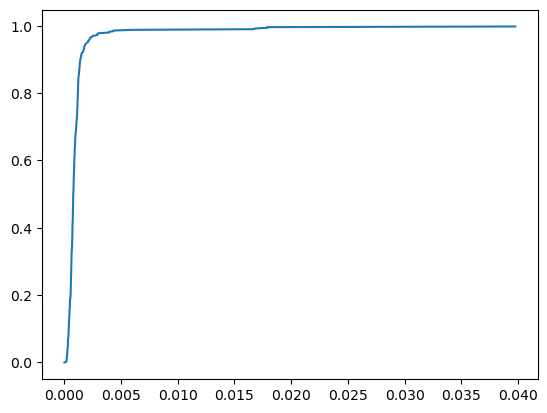

For  ER  :
curve_fit parameter on  logis:  [0.73628369 4.83264948]
curve_fit parameter on  t:  [0.73628358 2.41632273]
curve_fit parameter on  arc:  [0.72567085 4.91955878]
Gom: 6.189737720685944
curve_fit parameter on :  [0.73463573 1.97147661]
curve_fit parameter on  :  [0.73827385 2.0537824 ]
curve_fit parameter on  alge:  [0.70446435 0.3930957 ]
curve_fit parameter on  arctan:  [0.73391551 2.06616417 0.93513334]
arctan_GD: 6.192495175450399
curve_fit parameter on  Gompe:  [2.0384704  3.34191769]


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


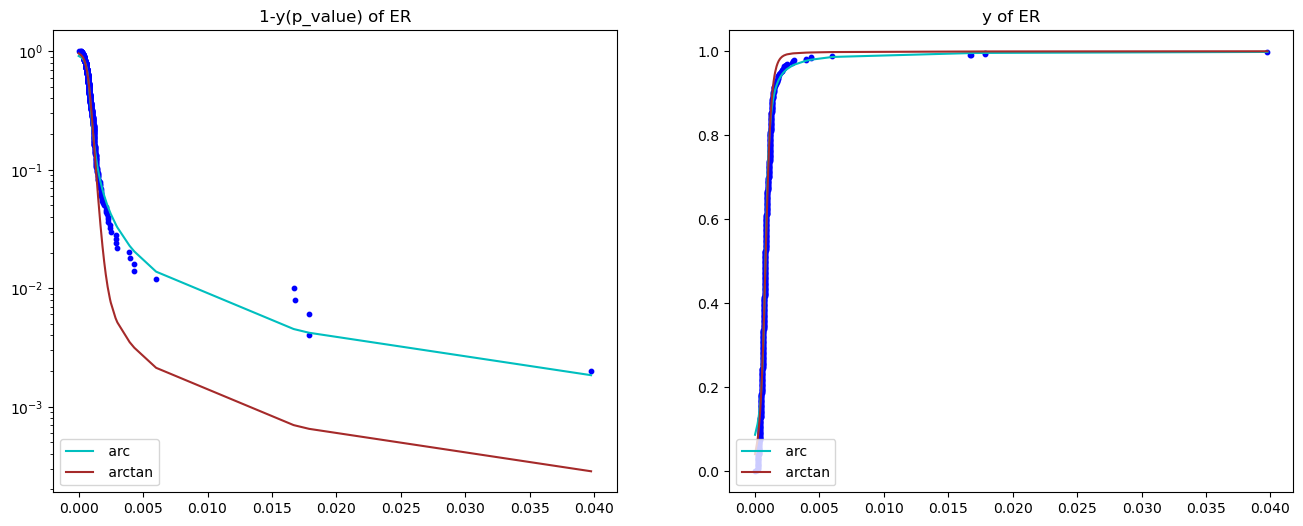

[0.00471642 0.00584116 0.00654668 0.00301772 0.00609634 0.0082428
 0.00528523 0.00540154 0.00931306 0.00358859 0.01435219 0.00849518
 0.00512199 0.00265852 0.00590748 0.0073724  0.00669064 0.0075347
 0.0044361  0.00397997 0.01109929 0.00881441 0.0071495  0.00673659
 0.00609634 0.00710911 0.00924168 0.00815909 0.00656803 0.00678896
 0.00452566 0.0067195  0.00385231 0.00863519 0.00933101 0.00800211
 0.00760618 0.00481302 0.00563391 0.00506779 0.00600196 0.00570165
 0.00459082 0.00507746 0.00591021 0.00466093 0.0073341  0.00336544
 0.00740639 0.00776179 0.00506621 0.00483979 0.00564345 0.00548156
 0.00942033 0.00841681 0.0031708  0.00530921 0.00928795 0.01044648
 0.00665152 0.0046785  0.00535781 0.00770939 0.0736576  0.00440622
 0.00711184 0.00614122 0.01023882 0.00368653 0.00581537 0.00658402
 0.00680271 0.00649629 0.00757864 0.00618381 0.00673177 0.00756654
 0.00486373 0.00708172 0.01007581 0.00653684 0.00742298 0.00778802
 0.00569863 0.00664215 0.00301772 0.00657078 0.00445347 0.003752

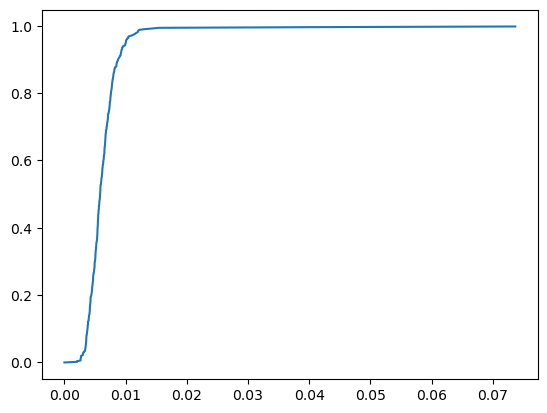

For  ERDD  :
curve_fit parameter on  logis:  [0.93977285 5.62836979]
curve_fit parameter on  t:  [0.93977282 2.81418421]
curve_fit parameter on  arc:  [0.93518574 5.59944197]
Gom: 6.205374845089775
curve_fit parameter on :  [0.93914601 2.2903952 ]
curve_fit parameter on  :  [0.94056846 2.3974882 ]
curve_fit parameter on  alge:  [0.92529588 0.29395796]
curve_fit parameter on  arctan:  [0.93971678 2.12118392 1.11329598]
arctan_GD: 6.203737561280922
curve_fit parameter on  Gompe:  [3.20165776 3.86266465]


/tmp/ipykernel_195/1069753868.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/tmp/ipykernel_195/1069753868.py:24: RuntimeWarning: invalid value encountered in divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


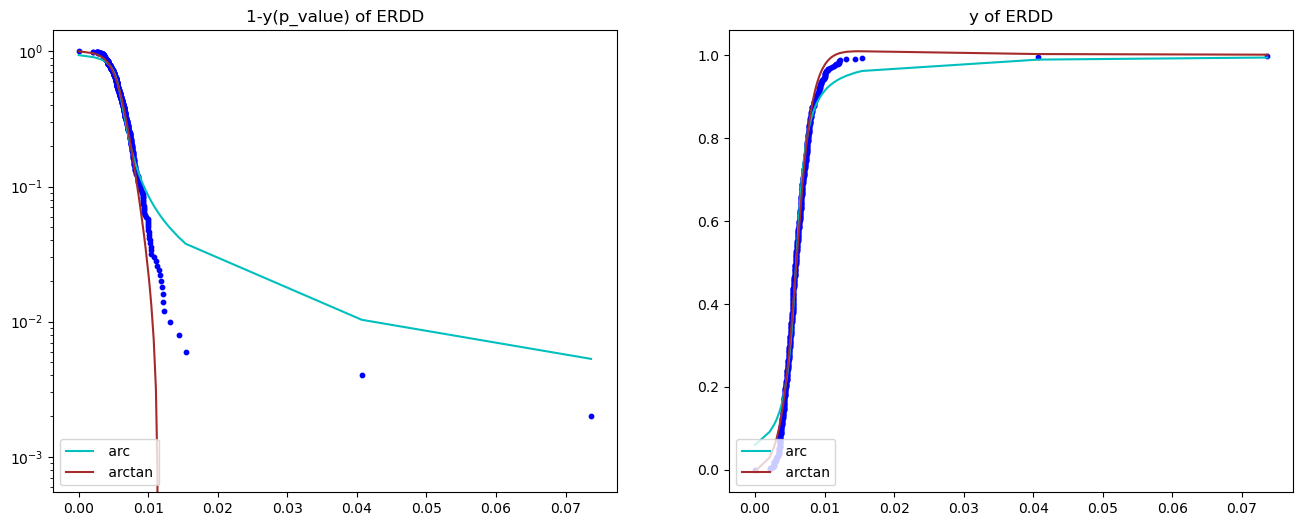

[0.00515515 0.02089514 0.00386447 0.00441778 0.00442521 0.00424682
 0.00292621 0.00436338 0.00410531 0.00535876 0.00245029 0.00305815
 0.00484173 0.00730075 0.00449821 0.00217614 0.00755522 0.00514636
 0.00256429 0.00466368 0.00389322 0.00480602 0.00578369 0.00350178
 0.00212048 0.00256914 0.02082874 0.00364492 0.00496914 0.0053183
 0.00208161 0.00281948 0.00830707 0.00268014 0.00565351 0.00490811
 0.00370725 0.00360888 0.00216727 0.00622152 0.00296139 0.0086031
 0.00292991 0.00268014 0.00753183 0.00601616 0.01237936 0.00730657
 0.00539444 0.00319539 0.00640196 0.00456447 0.00389106 0.00515985
 0.00603079 0.00410531 0.00412032 0.00505915 0.00414058 0.00389793
 0.00392198 0.00603027 0.00354543 0.01018573 0.00452959 0.00710391
 0.00417191 0.004945   0.00258949 0.00372155 0.00392198 0.00773973
 0.0066385  0.00315348 0.00623384 0.0023453  0.0053407  0.00275786
 0.00559854 0.00368532 0.00540382 0.01272417 0.00667933 0.00552902
 0.00279492 0.00338813 0.00441778 0.00456447 0.00761156 0.003577

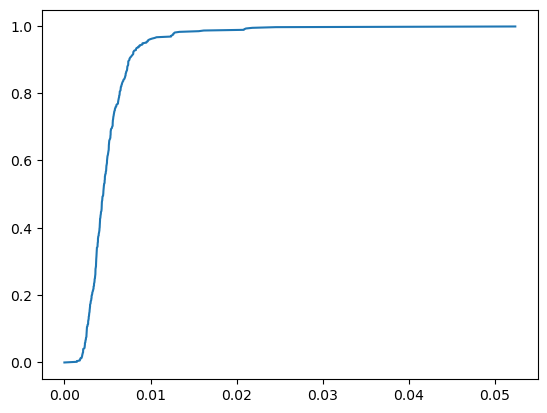

For  GEO  :
curve_fit parameter on  logis:  [0.89495814 4.78257486]
curve_fit parameter on  t:  [0.89495816 2.39128733]
curve_fit parameter on  arc:  [0.88640181 4.78343309]
Gom: 6.196579587088426
curve_fit parameter on :  [0.89356725 1.94807748]
curve_fit parameter on  :  [0.89697245 2.03210366]
curve_fit parameter on  alge:  [0.87540492 0.32861575]
curve_fit parameter on  arctan:  [0.89255192 2.08499791 0.90674857]
arctan_GD: 6.195619779613192
curve_fit parameter on  Gompe:  [2.52577069 3.29479778]


/tmp/ipykernel_195/1069753868.py:24: RuntimeWarning: divide by zero encountered in power
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/tmp/ipykernel_195/1069753868.py:24: RuntimeWarning: invalid value encountered in divide
  m = (1+x/((1+abs(x)**k)**(1/k)))/2
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


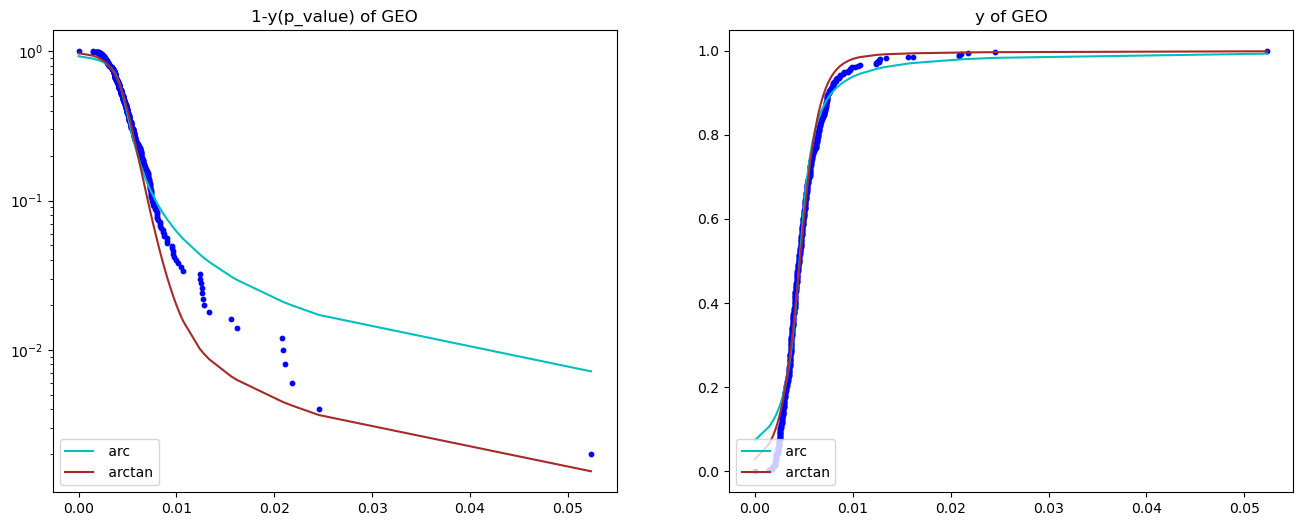

[0.00501236 0.01942659 0.01248454 0.00708165 0.01197147 0.0065505
 0.0045822  0.00770213 0.00292593 0.01688202 0.0074457  0.01288655
 0.01083132 0.00665397 0.01317729 0.02065549 0.02240296 0.02206304
 0.00824336 0.00613166 0.0058357  0.02526391 0.01873014 0.00718553
 0.00743108 0.0216239  0.06650367 0.00638179 0.02235244 0.00688277
 0.00663346 0.16150044 0.04957927 0.00901672 0.0255166  0.00705471
 0.04705035 0.00451901 0.00665397 0.00609522 0.02240296 0.00479439
 0.00558261 0.00411871 0.00986499 0.00624384 0.01893926 0.0157402
 0.01628419 0.00461681 0.01920084 0.01019056 0.01637693 0.02024792
 0.00982427 0.00714127 0.00292593 0.00508047 0.00558261 0.00458459
 0.00593225 0.00402468 0.00473855 0.00394467 0.00541797 0.00596165
 0.00606802 0.00524571 0.04467707 0.02124934 0.00862856 0.0198839
 0.01048302 0.00835853 0.04923268 0.01481665 0.01063393 0.01020367
 0.00587416 0.0052388  0.00573904 0.01317825 0.00351442 0.01409974
 0.00769106 0.02064399 0.010452   0.02490589 0.02570453 0.0424634

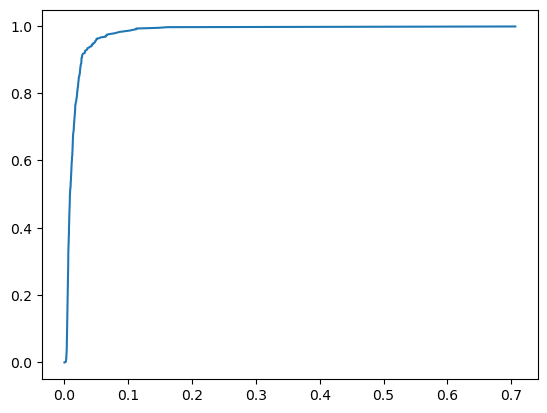

For  GEOGD  :
curve_fit parameter on  logis:  [0.64951251 3.54169119]
curve_fit parameter on  t:  [0.64951246 1.77084599]
curve_fit parameter on  arc:  [0.623884   3.46122865]
Gom: 6.171783675642519
curve_fit parameter on :  [0.64585616 1.43309349]
curve_fit parameter on  :  [0.65466273 1.51520909]
curve_fit parameter on  alge:  [0.54142298 0.48403531]
curve_fit parameter on  arctan:  [ 0.63285761  9.22985478 -1.19625578]
arctan_GD: 6.172920896064009
curve_fit parameter on  Gompe:  [1.23601869 2.57190664]


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


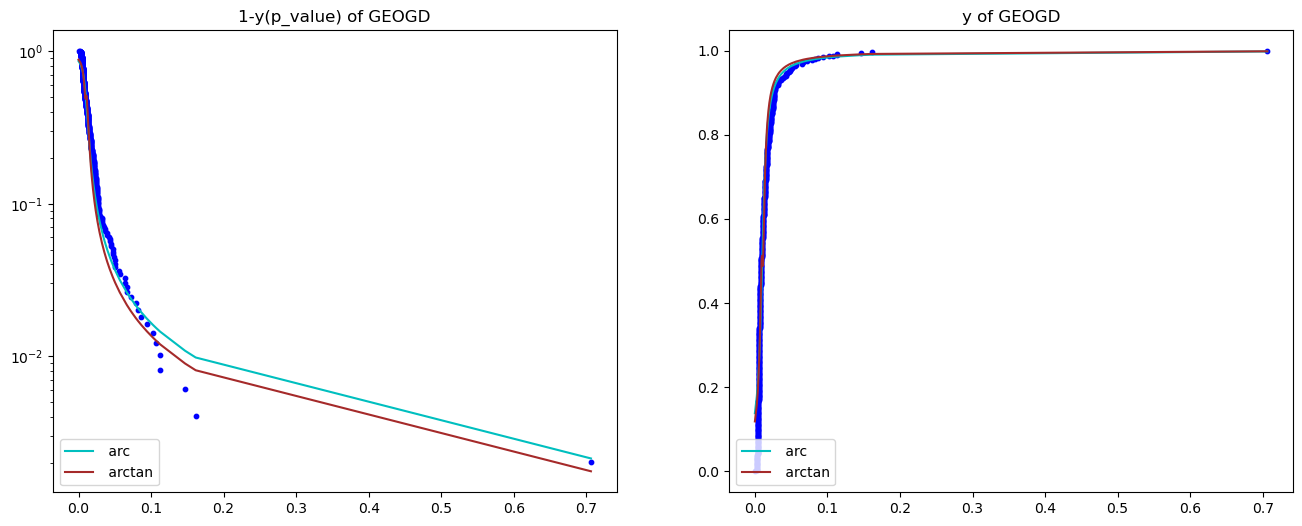

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


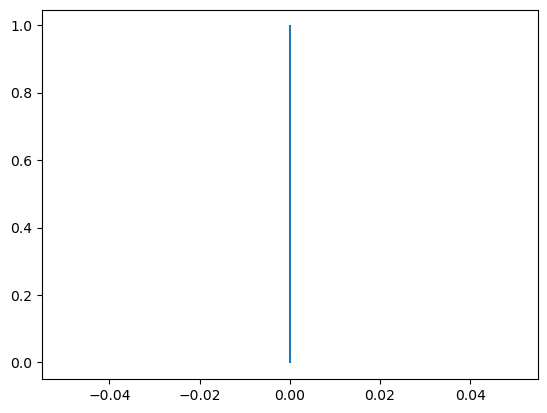

For  HGG  :


/tmp/ipykernel_195/2568539796.py:66: RuntimeWarning: invalid value encountered in double_scalars
  p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters
/tmp/ipykernel_195/2568539796.py:68: RuntimeWarning: invalid value encountered in divide
  popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm')


ValueError: array must not contain infs or NaNs

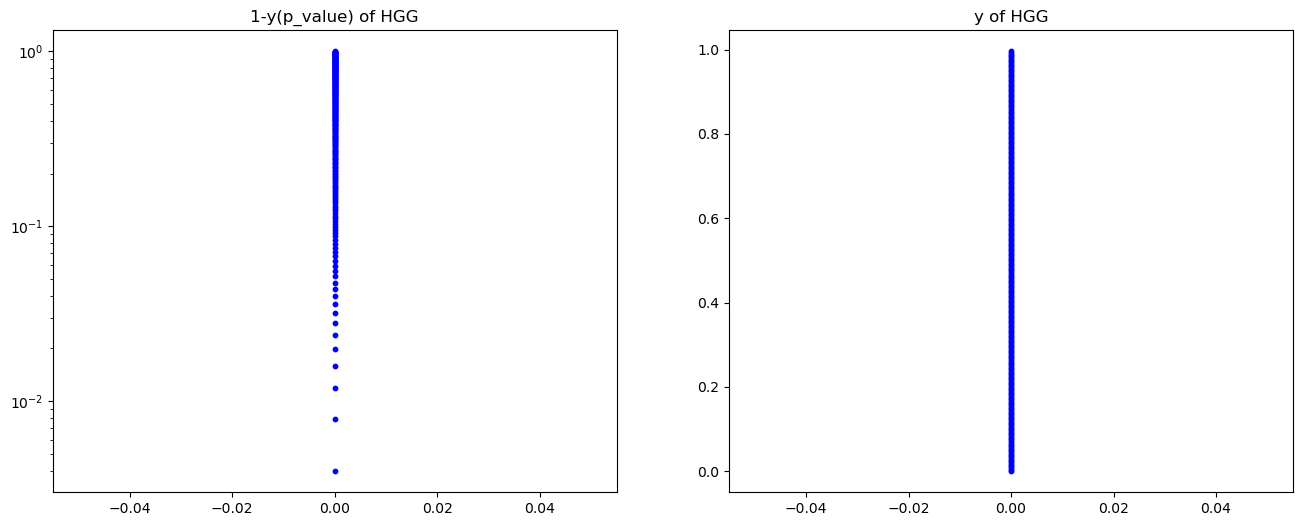

In [71]:
# AT
for i in range(len(classes_pred[:-1])):
    data_i = data_distance(data(df_comb,classes_pred[:-1][i]))
    sigmoids_for_class(data_i, classes_pred[:-1][i], np.mean(data_i), functions, colors)

In [ ]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_CE,classes[:-1][i]))
    sigmoids_for_class(data_i, classes[:-1][i], np.mean(data_i), functions, colors)

### Binning

In [ ]:
# binning first, add (0,0) at the front later when calculate y
#make it smooth

def data_binning(data):
    
    x = np.sort(data) 
    N = len(x)                   # e.g N = 500, sqrt(500)=22.3
    lower = int(np.floor(np.sqrt(N))) # 22
    upper = int(np.ceil(np.sqrt(N)))  # 23 as total #of bin
    
    if lower*upper >= N:
        small_bin_num = int(lower*upper - N)  # 22*23 - 500 = 6
        small_bin_size = int(lower - 1)  # 21
        large_bin_size = lower
    else: # HGG -> sqrt(252) = 15.8
        small_bin_num = int(upper**2 - N) # 16*16-252 =4
        small_bin_size = lower  # 15
        large_bin_size = upper
    
    large_bin_num = int(upper - small_bin_num) # 23-6 = 17

    # small_bin_size*small_bin_num + lower*large_bin_num = N

    bin_count = [large_bin_size]*large_bin_num + [small_bin_size]*small_bin_num  # [22..*17, 21..*6,]
    print("items in each bin: ", bin_count)
    binned_data = []
    i = 0
    for count in bin_count:
        binned_data.append(np.mean(x[i:i+count]))
        i += count
    
    return binned_data


def binning_xy(binned_data):
    x = np.concatenate(([0],binned_data))
    y = np.zeros((x.shape))
    
    for i in range(1,len(x)):
        y[i] = i/len(x)
        
    return x,y
 

#### AT

In [ ]:
# for i in range(len(classes[:-1])):
#     data_i = data_distance(data(df_comb,classes[:-1][i]))
#     sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

#### CE

In [ ]:
# for i in range(len(classes[:-1])):
#     data_i = data_distance(data(df_CE,classes[:-1][i]))
#     sigmoids_for_class(data_i, classes[:-1][i], factors[i], functions, colors,binning=True)

In [ ]:
# arctan_popt

In [ ]:
def euclid(origin, other):
  return np.sum((origin - other) ** 2)**(1/2)

def NN_distance(ref_point, data):
  nearest_distance = 1e999
  for point in data:
    if euclid(ref_point, point) < nearest_distance: 
      nearest_distance = euclid(ref_point, point)
  return nearest_distance

# NN_dict = {}

In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in arctan_popt:
  nearest_distance = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
  #print(*arctan_popt[f'{target}'])
  #print(nearest_distance)
  # NN_dict["arctan_GD"] = nearest_distance
  #print("--")
  print(arctan_GD(nearest_distance,*arctan_popt[f'{target}']))
  #least square fittinhg, make it as a library, can only have dataset with numbers, no images
  #different variables, weigh in a approtate place
  #create a library, then find a new data never see before, test it 
  #uci ml repository

In [ ]:
original = df_comb[df_comb['class'] == 'Original']
for target in arctan_popt:
  nearest_distance = NN_distance(original.drop(['class'], axis = 1).to_numpy(), df_comb[df_comb['class'] == f'{target}'].drop(['class'], axis = 1).to_numpy())
  print(ERF(nearest_distance,*arctan_popt[f'{target}']))